<a href="https://colab.research.google.com/github/gaurkuldeep/Titanic-Survival-Prediction/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/titanic.csv')

In [ ]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (418, 12)

First few rows:
   PassengerId  Survived  Pclass  \
0          892         0       3   
1          893         1       3   
2          894         0       2   
3          895         0       3   
4          896         1       3   

                                           Name     Sex   Age  SibSp  Parch  \
0                              Kelly, Mr. James    male  34.5      0      0   
1              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   
2                     Myles, Mr. Thomas Francis    male  62.0      0      0   
3                              Wirz, Mr. Albert    male  27.0      0      0   
4  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1   

    Ticket     Fare Cabin Embarked  
0   330911   7.8292   NaN        Q  
1   363272   7.0000   NaN        S  
2   240276   9.6875   NaN        Q  
3   315154   8.6625   NaN        S  
4  3101298  12.2875   NaN        S  

Dataset Info:
<class 'pandas.core.frame.Dat

In [ ]:
# Exploratory Data Analysis
print("\n=== EXPLORATORY DATA ANALYSIS ===")
print(f"Survival Rate: {df['Survived'].mean():.2%}")
print(f"Survival by Class:\n{df.groupby('Pclass')['Survived'].mean()}")
print(f"Survival by Sex:\n{df.groupby('Sex')['Survived'].mean()}")


=== EXPLORATORY DATA ANALYSIS ===
Survival Rate: 36.36%
Survival by Class:
Pclass
1    0.467290
2    0.322581
3    0.330275
Name: Survived, dtype: float64
Survival by Sex:
Sex
female    1.0
male      0.0
Name: Survived, dtype: float64


In [ ]:
# Feature Engineering and Preprocessing
def preprocess_data(df):
    df_processed = df.copy()

# Handle missing values
# Age - impute with median
    age_imputer = SimpleImputer(strategy='median')
    df_processed['Age'] = age_imputer.fit_transform(df_processed[['Age']])


# Fare - impute with median
    fare_imputer = SimpleImputer(strategy='median')
    df_processed['Fare'] = fare_imputer.fit_transform(df_processed[['Fare']])

# Embarked - impute with mode
    df_processed['Embarked'] = df_processed['Embarked'].fillna(df_processed['Embarked'].mode()[0])

# Cabin - create binary feature indicating whether cabin info is available
    df_processed['Has_Cabin'] = df_processed['Cabin'].notna().astype(int)

# Feature Engineering
    # Family size
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1

# Is alone
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)

# Age groups
    df_processed['AgeGroup'] = pd.cut(df_processed['Age'],
                                   bins=[0, 12, 18, 35, 60, 100],
                                   labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])

# Fare groups
    df_processed['FareGroup'] = pd.qcut(df_processed['Fare'], 4,
                                      labels=['Low', 'Medium', 'High', 'Very High'])


# Title extraction from Name
    df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df_processed['Title'] = df_processed['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                        'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                        'Jonkheer', 'Dona'], 'Rare')
    df_processed['Title'] = df_processed['Title'].replace('Mlle', 'Miss')
    df_processed['Title'] = df_processed['Title'].replace('Ms', 'Miss')
    df_processed['Title'] = df_processed['Title'].replace('Mme', 'Mrs')

    return df_processed

<>:39: SyntaxWarning: invalid escape sequence '\.'
<>:39: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-2732910411.py:39: SyntaxWarning: invalid escape sequence '\.'
  df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


In [ ]:
# Preprocess the data
df_processed = preprocess_data(df)
print("\n=== AFTER PREPROCESSING ===")
print("Missing values after preprocessing:")
print(df_processed.isnull().sum())


=== AFTER PREPROCESSING ===
Missing values after preprocessing:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Has_Cabin        0
FamilySize       0
IsAlone          0
AgeGroup         0
FareGroup        0
Title            0
dtype: int64


In [ ]:
# Select features for modeling
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
           'Has_Cabin', 'FamilySize', 'IsAlone', 'Title']

X = df_processed[features]
y = df_processed['Survived']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (418, 11)
Target shape: (418,)


In [ ]:
# Encode categorical variables
categorical_features = ['Sex', 'Embarked', 'AgeGroup', 'FareGroup', 'Title']
numerical_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Has_Cabin']

In [ ]:
# Create encoded features
X_encoded = X[numerical_features].copy()

In [ ]:
# Encode categorical variables
label_encoders = {}
for feature in ['Sex', 'Embarked', 'Title']:
    le = LabelEncoder()
    X_encoded[feature] = le.fit_transform(X[feature].astype(str))
    label_encoders[feature] = le

print(f"\nEncoded features shape: {X_encoded.shape}")
print("\nFeature names:", X_encoded.columns.tolist())


Encoded features shape: (418, 11)

Feature names: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'IsAlone', 'Has_Cabin', 'Sex', 'Embarked', 'Title']


In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== DATA SPLIT ===")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training survival rate: {y_train.mean():.2%}")
print(f"Test survival rate: {y_test.mean():.2%}")


=== DATA SPLIT ===
Training set: 334 samples
Test set: 84 samples
Training survival rate: 36.23%
Test survival rate: 36.90%


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n=== MODEL TRAINING ===")
# Train Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)


=== MODEL TRAINING ===


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Make predictions
y_pred = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))

print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 1.0000
AUC Score: 1.0000

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84


=== CONFUSION MATRIX ===
[[53  0]
 [ 0 31]]


In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': abs(logreg.coef_[0])
}).sort_values('importance', ascending=False)

print("\n=== FEATURE IMPORTANCE ===")
print(feature_importance)


=== FEATURE IMPORTANCE ===
       feature  importance
8          Sex    4.148589
6      IsAlone    0.170179
4         Fare    0.131945
1          Age    0.058254
9     Embarked    0.054282
7    Has_Cabin    0.046029
3        Parch    0.037375
2        SibSp    0.032735
0       Pclass    0.028993
10       Title    0.004933
5   FamilySize    0.003021


In [ ]:
# Visualizations
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

Text(0.5, 0, 'Importance')

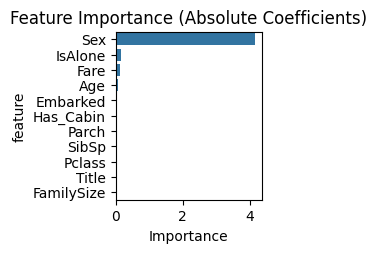

In [ ]:
# 1. Feature Importance
plt.subplot(2, 3, 1)
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance (Absolute Coefficients)')
plt.xlabel('Importance')

Text(0.5, 225.12222222222223, 'Predicted')

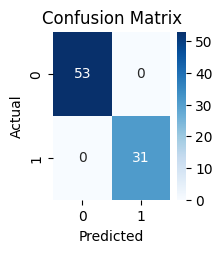

In [ ]:
# 2. Confusion Matrix
plt.subplot(2, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

Text(0, 0.5, 'Survival Rate')

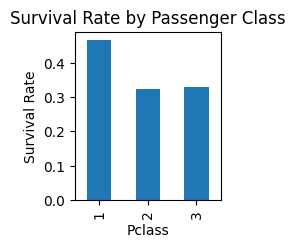

In [ ]:
# 3. Survival by Class
plt.subplot(2, 3, 3)
df.groupby('Pclass')['Survived'].mean().plot(kind='bar')
plt.title('Survival Rate by Passenger Class')
plt.ylabel('Survival Rate')

Text(0, 0.5, 'Survival Rate')

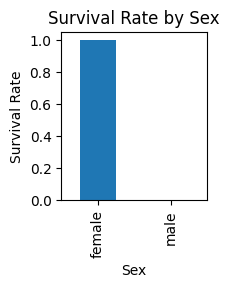

In [ ]:
# 4. Survival by Sex
plt.subplot(2, 3, 4)
df.groupby('Sex')['Survived'].mean().plot(kind='bar')
plt.title('Survival Rate by Sex')
plt.ylabel('Survival Rate')

Text(0.5, 1.0, 'Age Distribution by Survival')

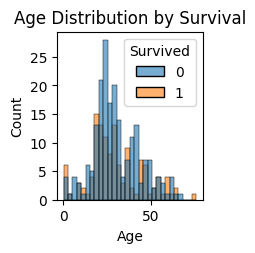

In [ ]:
# 5. Age distribution by survival
plt.subplot(2, 3, 5)
sns.histplot(data=df, x='Age', hue='Survived', bins=30, alpha=0.6)
plt.title('Age Distribution by Survival')

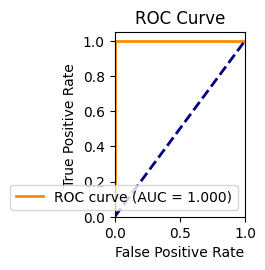

In [ ]:
# 6. ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.subplot(2, 3, 6)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
# Model coefficients analysis
coefficients = pd.DataFrame({
    'feature': X_encoded.columns,
    'coefficient': logreg.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\n=== MODEL COEFFICIENTS ===")
print(coefficients)


=== MODEL COEFFICIENTS ===
       feature  coefficient
4         Fare     0.131945
7    Has_Cabin     0.046029
3        Parch     0.037375
5   FamilySize     0.003021
10       Title    -0.004933
0       Pclass    -0.028993
2        SibSp    -0.032735
9     Embarked    -0.054282
1          Age    -0.058254
6      IsAlone    -0.170179
8          Sex    -4.148589


In [ ]:
# Interpretation
print("\n=== KEY INSIGHTS ===")
print("1. Positive coefficients increase survival probability:")
positive_features = coefficients[coefficients['coefficient'] > 0]
for _, row in positive_features.iterrows():
    print(f"   - {row['feature']}: +{row['coefficient']:.3f}")

print("\n2. Negative coefficients decrease survival probability:")
negative_features = coefficients[coefficients['coefficient'] < 0]
for _, row in negative_features.iterrows():
    print(f"   - {row['feature']}: {row['coefficient']:.3f}")


=== KEY INSIGHTS ===
1. Positive coefficients increase survival probability:
   - Fare: +0.132
   - Has_Cabin: +0.046
   - Parch: +0.037
   - FamilySize: +0.003

2. Negative coefficients decrease survival probability:
   - Title: -0.005
   - Pclass: -0.029
   - SibSp: -0.033
   - Embarked: -0.054
   - Age: -0.058
   - IsAlone: -0.170
   - Sex: -4.149


In [ ]:
# Cross-validation for more robust evaluation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\n=== CROSS-VALIDATION RESULTS ===")
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Predict survival probability for a sample passenger
sample_passenger = X_encoded.iloc[0:1].copy()
sample_scaled = scaler.transform(sample_passenger)
survival_prob = logreg.predict_proba(sample_scaled)[0, 1]
print(f"\nSample passenger survival probability: {survival_prob:.1%}")


=== CROSS-VALIDATION RESULTS ===
CV Accuracy: 1.0000 (+/- 0.0000)

Sample passenger survival probability: 0.8%
